### The goal of this notebook is to assess, in various way, the relative efficiency of using a pandas dataframe and of using person objects to process population information, using either a single core or more than one cores. 

In [33]:
#the code that implemented the multiprocessing module was written in 2019:
# https://github.com/jburke5/microsim/commit/1f3db94da9d0ffd698d63a3785eed33fa7a36af1

In [1]:
import os
import time
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
import statistics
import multiprocessing as mp
from DataframeVsObjectsDefinitions import *
from functools import reduce
import operator
import pickle

In [2]:
from microsim.population import NHANESDirectSamplePopulation
from microsim.sim_settings import simSettings
from microsim.cohort_risk_model_repository import CohortRiskModelRepository

In [3]:
#pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = False 

seedSequence = np.random.SeedSequence()
rngStream = np.random.default_rng(seed=seedSequence)

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [27]:
#run small popSizes only during development...
popSizes = [2]*10 + [10]*10 + [100]*10 +[1000]*10 + [10000]*10 + [100000]*10
nProcesses = 2

### TEST 0 : appending results

In [ ]:
timesDf = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)
rf = "a1c"

#interestingly, when I initialize the model here, versus initializing during apply, it makes no effect on the performance
#I wonder if pandas apply initializes the function only once and then applies the same instance
model = CohortRiskModelRepository().get_model("a1c")

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        
    aliveCopy = alive.copy()
    
    riskFactorsDict = {}
    tempDf = pd.DataFrame.apply(aliveCopy, 
                                #CohortRiskModelRepository().get_model(rf).estimate_next_risk_vectorized,
                                model.estimate_next_risk_vectorized,
                                axis="columns", rng=rngStream)
    
    startTime = time.time()
    riskFactorsDict[rf + "Next"] = tempDf   
    aliveCopy = pd.concat([aliveCopy.reset_index(drop=True), 
                       pd.DataFrame(riskFactorsDict).reset_index(drop=True)], 
                       axis='columns', ignore_index=False)
    endTime = time.time()
    
    timesDf += [(endTime-startTime)/1.]

In [ ]:
resultsDf = pd.DataFrame( list(zip(popSizes,timesDf)), columns =['popSize', 'time'])
resultsDfMeans = resultsDf.groupby("popSize").agg({'time' : 'mean'})
resultsDfMeans.rename(columns={"time": "timeDfApp"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsDfMeans.index.tolist(),resultsDfMeans["timeDfApp"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)
#initializing the model takes a relatively huge amount of time so I need to do it once
#but advance_year and then advance_riskfactors is initializing the model every time for every person
model = CohortRiskModelRepository().get_model(rf)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        
    startTime = time.time()
    list(map( lambda x: x._a1c.append(3.1), pop._people.iloc[:] ))
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

In [ ]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObApp"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObApp"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
resultsMeans = pd.concat([resultsDfMeans,resultsObMeans],axis=1)
resultsMeans

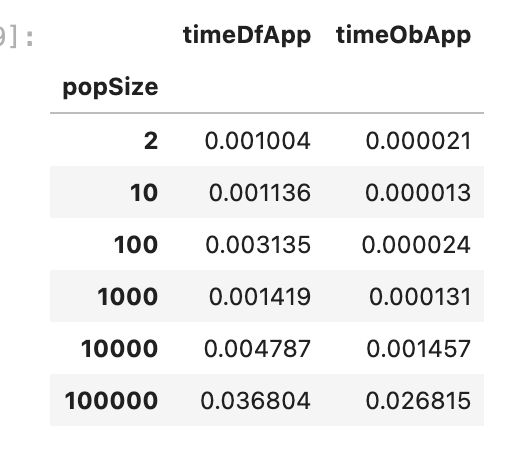

In [ ]:
#appending results is of comparable order of magnitude, a bit faster using the objects 

### TEST 1: apply a function on the population and append the results

In [ ]:
timesDf = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)
rf = "a1c"
#interestingly, when I initialize the model here, versus initializing during apply, it makes no effect on the performance
#I wonder if pandas apply initializes the function only once and then applies the same instance
model = CohortRiskModelRepository().get_model("a1c")

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        
    aliveCopy = alive.copy()
    startTime = time.time()
    
    riskFactorsDict = {}
    riskFactorsDict[rf + "Next"] = pd.DataFrame.apply(aliveCopy, 
                                                      #CohortRiskModelRepository().get_model(rf).estimate_next_risk_vectorized,
                                                      model.estimate_next_risk_vectorized,
                                                      axis="columns",
                                                      rng=rngStream)
    aliveCopy = pd.concat([aliveCopy.reset_index(drop=True), 
                       pd.DataFrame(riskFactorsDict).reset_index(drop=True)], 
                       axis='columns', ignore_index=False)
    endTime = time.time()
    
    timesDf += [(endTime-startTime)/1.]

In [ ]:
resultsDf = pd.DataFrame( list(zip(popSizes,timesDf)), columns =['popSize', 'time'])
resultsDfMeans = resultsDf.groupby("popSize").agg({'time' : 'mean'})
resultsDfMeans.rename(columns={"time": "timeDfRf"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsDfMeans.index.tolist(),resultsDfMeans["timeDfRf"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)
#initializing the model takes a relatively huge amount of time so I need to do it once
#but advance_year and then advance_riskfactors is initializing the model every time for every person
model = CohortRiskModelRepository().get_model(rf)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        
    startTime = time.time()
    
    #for loops: slowest option
    #for personOb in  pop._people.iloc[:]:
    #    personOb._a1c.append(personOb.get_next_risk_factor("a1c", CohortRiskModelRepository() , rng=rngStream))
    
    #very slow to initialize risk model each time
    #list(map( lambda x: x._a1c.append(x.get_next_risk_factor("a1c", CohortRiskModelRepository() , rng=rngStream)), pop._people.iloc[:] ))

    list(map( lambda x: x._a1c.append(model.estimate_next_risk(x, rng=rngStream)), pop._people.iloc[:] ))
    
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

In [ ]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObRf"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObRf"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
resultsMeans = pd.concat([resultsDfMeans,resultsObMeans],axis=1)
resultsMeans

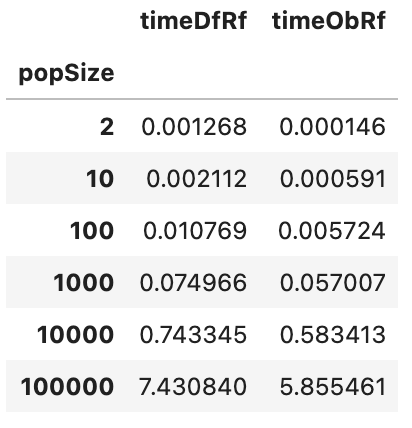

In [ ]:
#doing a risk factor calculation and appending the results is comparable in df and ob approaches
#with the objects a bit faster

#doing the calculation is the dominant part of the computing time, appending the results does not take much time

#when a model needs to be initialized, it should be initialized only once, prior to applying the function
#perhaps pandas apply does that by default

### TEST 2: cost of using multiple columns

In [ ]:
timesDf = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        for j in range(0,20):
            alive[f"random{j}"] = np.random.uniform(size=alive.shape[0])
        alive["random"] = np.random.uniform(size=20*alive.shape[0]).reshape((alive.shape[0], 20)).tolist()
           
    aliveCopy = alive.copy()
    
    startTime = time.time()
    
    #test accessing multiple columns
    #if there is a pandas function, that is the fastest way to go
    #aliveCopy["randomMean"] = aliveCopy[[f"random{x}" for x in range(0,20)]].mean(axis=1)
    
    #this is orders of magnitude slower but perhaps there may not exist a native pandas function for everything 
    #this is a more realistic comparison, since we will not be using native pandas functions to calculate risks etc
    aliveCopy["randomMean"] = pd.DataFrame.apply(aliveCopy[[f"random{x}" for x in range(0,20)]],np.mean, axis=1)
    
    endTime = time.time()
    
    timesDf += [(endTime-startTime)/1.]

In [ ]:
resultsDf = pd.DataFrame( list(zip(popSizes,timesDf)), columns =['popSize', 'time'])
resultsDfMeans = resultsDf.groupby("popSize").agg({'time' : 'mean'})
resultsDfMeans.rename(columns={"time": "timeDfMc"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsDfMeans.index.tolist(),resultsDfMeans["timeDfMc"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        #list(map( lambda x: setattr(x, "_a1c", np.random.uniform(size=20).tolist()), pop._people.iloc[:]))
        for j in range(0,20):
            list(map( lambda x: setattr(x, f"random{j}", np.random.uniform()), pop._people.iloc[:]))
        
    startTime = time.time()
    
    #numpy mean is 1 order of magnitude faster than statistics.mean
    #list(map(lambda x: setattr(x, "randomMean", np.mean(x._a1c)), pop._people.iloc[:] ))
    #list(map(lambda x: setattr(x, "randomMean", statistics.mean(x._a1c)), pop._people.iloc[:] ))

    list(map(lambda x: setattr(x, "randomMean", np.mean([getattr(x, f"random{j}") for j in range(0,20)])), pop._people.iloc[:] ))
    
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

In [ ]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObMc"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObMc"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
resultsMeans = pd.concat([resultsDfMeans,resultsObMeans],axis=1)
resultsMeans

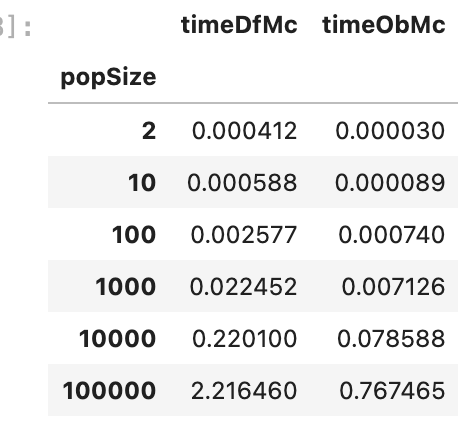

In [ ]:
#the df approach is about 3 times slower 
#using multiple df columns is about 3 times slower than using multiple object attributes

### TEST 3: cost of using multiple columns after advancing N years

In [28]:
timesDf = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(5,rng=rngStream)
        for j in range(0,20):
            alive[f"random{j}"] = np.random.uniform(size=alive.shape[0])
        alive["random"] = np.random.uniform(size=20*alive.shape[0]).reshape((alive.shape[0], 20)).tolist()
           
    aliveCopy = alive.copy()
    
    startTime = time.time()
    
    #test accessing multiple columns
    #if there is a pandas function, that is the fastest way to go
    #aliveCopy["randomMean"] = aliveCopy[[f"random{x}" for x in range(0,20)]].mean(axis=1)
    
    #this is orders of magnitude slower but perhaps there may not exist a native pandas function for everything 
    #this is a more realistic comparison, since we will not be using native pandas functions to calculate risks etc
    aliveCopy["randomMean"] = pd.DataFrame.apply(aliveCopy[[f"random{x}" for x in range(0,20)]],np.mean, axis=1)
    
    endTime = time.time()
    
    timesDf += [(endTime-startTime)/1.]

0 2
10 10
20 100
30 1000
40 10000
50 100000


In [29]:
resultsDf = pd.DataFrame( list(zip(popSizes,timesDf)), columns =['popSize', 'time'])
resultsDfMeans = resultsDf.groupby("popSize").agg({'time' : 'mean'})
resultsDfMeans.rename(columns={"time": "timeDfMc"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsDfMeans.index.tolist(),resultsDfMeans["timeDfMc"].values)
ax.set_xscale("log")
plt.close(fig)

In [30]:
timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(5,rng=rngStream)
        #list(map( lambda x: setattr(x, "_a1c", np.random.uniform(size=20).tolist()), pop._people.iloc[:]))
        for j in range(0,20):
            list(map( lambda x: setattr(x, f"random{j}", np.random.uniform()), pop._people.iloc[:]))
        
    startTime = time.time()
    
    #numpy mean is 1 order of magnitude faster than statistics.mean
    #list(map(lambda x: setattr(x, "randomMean", np.mean(x._a1c)), pop._people.iloc[:] ))
    #list(map(lambda x: setattr(x, "randomMean", statistics.mean(x._a1c)), pop._people.iloc[:] ))

    list(map(lambda x: setattr(x, "randomMean", np.mean([getattr(x, f"random{j}") for j in range(0,20)])), pop._people.iloc[:] ))
    
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

0 2
10 10
20 100
30 1000
40 10000
50 100000


In [31]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObMc"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObMc"].values)
ax.set_xscale("log")
plt.close(fig)

In [32]:
resultsMeans = pd.concat([resultsDfMeans,resultsObMeans],axis=1)
resultsMeans

,timeDfMc,timeObMc
popSize,,
2,0.000447,0.000030
10,0.000565,0.000089
100,0.002491,0.000727
1000,0.021962,0.006823
10000,0.223630,0.071271
100000,2.165014,0.726508


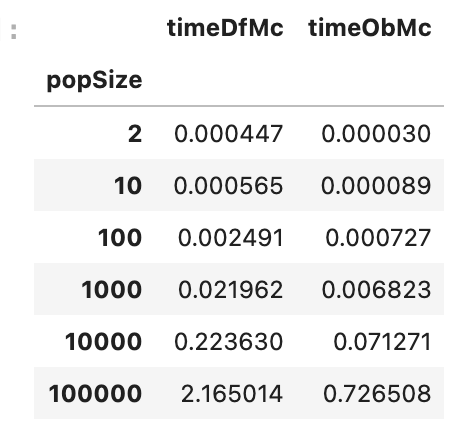

In [34]:
#there is no significant difference if the population has a few more years of information

### TEST 4: cost of accessing a single column-list

In [ ]:
timesDf = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        for j in range(0,20):
            alive[f"random{j}"] = np.random.uniform(size=alive.shape[0])
        alive["random"] = np.random.uniform(size=20*alive.shape[0]).reshape((alive.shape[0], 20)).tolist()
           
    aliveCopy = alive.copy()
    
    startTime = time.time()
    
    aliveCopy["randomMean"] = aliveCopy["random"].apply(lambda x: np.mean(x))
    
    endTime = time.time()
    
    timesDf += [(endTime-startTime)/1.]

In [ ]:
resultsDf = pd.DataFrame( list(zip(popSizes,timesDf)), columns =['popSize', 'time'])
resultsDfMeans = resultsDf.groupby("popSize").agg({'time' : 'mean'})
resultsDfMeans.rename(columns={"time": "timeDfCl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsDfMeans.index.tolist(),resultsDfMeans["timeDfCl"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        list(map( lambda x: setattr(x, "random", np.random.uniform(size=20).tolist()), pop._people.iloc[:]))
        for j in range(0,20):
            list(map( lambda x: setattr(x, f"random{j}", np.random.uniform()), pop._people.iloc[:]))
        
    startTime = time.time()
    
    #numpy mean is 1 order of magnitude faster than statistics.mean
    list(map(lambda x: setattr(x, "randomMean", np.mean(x.random)), pop._people.iloc[:] ))
    #list(map(lambda x: setattr(x, "randomMean", statistics.mean(x._a1c)), pop._people.iloc[:] ))
    
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

In [ ]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObCl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObCl"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
resultsMeans = pd.concat([resultsDfMeans,resultsObMeans],axis=1)
resultsMeans

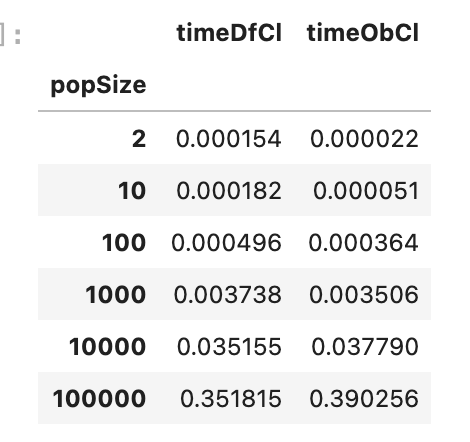

In [ ]:
#times are of comparable order of magnitude
#the df approach of using a single column-list is a bit faster than using a single attribute list from person objects

#also, the cost of accessing multiple columns is many times greater than accessing a list in a single column
#whereas for person objects the cost is multiplied by about 2 (accessing 20 attributes vs a single list attribute)

### TEST 5: cost of accessing multiple column-lists and multiple object attributes

In [ ]:
timesDf = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        for j in range(0,20):
            alive[f"random{j}"] = np.random.uniform(size=20*alive.shape[0]).reshape((alive.shape[0], 20)).tolist()
           
    aliveCopy = alive.copy()
    
    startTime = time.time()
    
    #aliveCopy["randomMean"] = aliveCopy[[f"random{x}" for x in range(0,20)]].applymap(lambda x: x[3]).mean(axis=1)
    
    #aliveCopy["randomMean"] = pd.DataFrame.apply(aliveCopy[[f"random{x}" for x in range(0,20)]].applymap(lambda x: x[3]),np.mean, axis=1)
    
    aliveCopy["randomMean"] = (aliveCopy[[f"random{x}" for x in range(0,20)]]
                               .applymap(lambda x: x[3])
                               .apply(lambda y: [y[f"random{x}"] for x in range(0,20)],axis=1)
                               .apply(lambda x: np.mean(x)))

    endTime = time.time()
    
    timesDf += [(endTime-startTime)/1.]

In [ ]:
#aliveCopy[[f"random{x}" for x in range(0,20)]].applymap(lambda x: x[3]).head()
#aliveCopy[[f"random{x}" for x in range(0,20)]].applymap(lambda x: x[3]).apply(lambda y: [y[f"random{x}"] for x in range(0,20)],axis=1)

In [ ]:
resultsDf = pd.DataFrame( list(zip(popSizes,timesDf)), columns =['popSize', 'time'])
resultsDfMeans = resultsDf.groupby("popSize").agg({'time' : 'mean'})
resultsDfMeans.rename(columns={"time": "timeDfMcl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsDfMeans.index.tolist(),resultsDfMeans["timeDfMcl"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        for j in range(0,20):
            list(map( lambda x: setattr(x, f"random{j}", np.random.uniform(size=20).tolist()), pop._people.iloc[:]))
        
    startTime = time.time()
    
    list(map(lambda x: setattr(x, "randomMean", np.mean(
        [getattr(x, f"random{j}")[3] for j in range(0,20)] )), pop._people.iloc[:] ))
        
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

In [ ]:
#pop._people.iloc[0].random1

In [ ]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObMcl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObMcl"].values)
ax.set_xscale("log")
plt.close(fig)

In [ ]:
resultsMeans = pd.concat([resultsDfMeans,resultsObMeans],axis=1)
resultsMeans

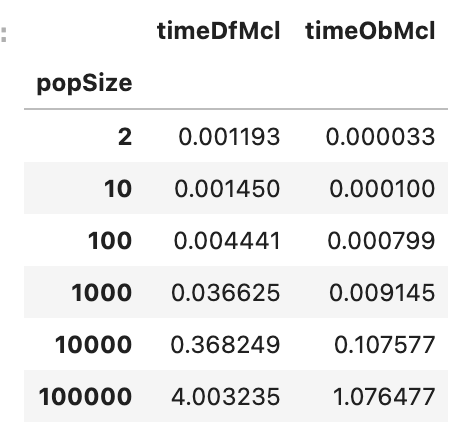

In [ ]:
#df approach is 4 times slower
#accessing multiple list-columns on a df is 4 times slower than using mutiple list-attributes

### TEST 6: cost to parallelize dataframe and objects for a single column-list

Note: In this section I am not comparing a df implementation vs an object implementation, rather I am trying different things and look at their 
computing cost

In [ ]:
timesDf = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        for j in range(0,20):
            alive[f"random{j}"] = np.random.uniform(size=alive.shape[0])
        alive["random"] = np.random.uniform(size=20*alive.shape[0]).reshape((alive.shape[0], 20)).tolist()
    
    #use a copy, I do not want to alter the original alive df since I will be using it in all iterations for a given pop size
    aliveCopy = alive.copy()
    aliveCopySplit = np.array_split(aliveCopy, nProcesses)
    
    startTime = time.time()
    
    #0.006 for a 10k pop
    aliveCopySerialized = pickle.dumps(aliveCopySplit)
    
    endTime = time.time()
    
    timesDf += [(endTime-startTime)/1.]

In [ ]:
resultsDf = pd.DataFrame( list(zip(popSizes,timesDf)), columns =['popSize', 'time'])
resultsDfMeans = resultsDf.groupby("popSize").agg({'time' : 'mean'})
resultsDfMeans.rename(columns={"time": "timeDfPcl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsDfMeans.index.tolist(),resultsDfMeans["timeDfPcl"].values)
ax.set_xscale("log")
plt.close(fig)

resultsDfMeans

In [ ]:
timesDf = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        for j in range(0,20):
            alive[f"random{j}"] = np.random.uniform(size=alive.shape[0])
        alive["random"] = np.random.uniform(size=20*alive.shape[0]).reshape((alive.shape[0], 20)).tolist()
    
    #use a copy, I do not want to alter the original alive df since I will be using it in all iterations for a given pop size
    aliveCopy = alive.copy()
    
    #if you want to test a huge list of pd series...
    #when we use the df approach we pass only two things (for 2 processes, the two halves of the alive dataframe)
    #so I wanted to see if it is the type of data structure that makes the difference or the number of
    #arguments that are passed on to the pool...
    #aliveSeries = [aliveCopy.iloc[i] for i in aliveCopy.index]
    
    startTime = time.time()
    
    if __name__ == '__main__':
        with mp.Pool(nProcesses) as pool:
            aliveCopySplit = np.array_split(aliveCopy, nProcesses)
            
            #the actual calculation of a column-list
            aliveCopy["randomMean"] = pd.concat(pool.map(meanOfList, aliveCopySplit))
            
            #if you want to see the relative cost of multiprocessing overhead vs actual computing cost
            #(I am not interested so much as to what happens when the results are back)
            #overhead cost 0.44, cost/iteration 0.017
            #a = pool.map(meanOfListNTimes, aliveCopySplit) #2.16
            #a = pool.map(meanOfList, aliveCopySplit) #0.46
            
            #if you want to see cost of data transfer back and forth
            #a = pool.map(doNothingReturnArg, aliveCopySplit)
            #if you want to see cost of data transfer one way only
            #a = pool.map(doNothingReturn0, aliveCopySplit)
            
            #if you want to see cost of moving back and forth a large list of pd series 
            #a huge list of pd series takes a very long time
            #a = pool.map(doNothingReturnArg, aliveSeries)

    endTime = time.time()
    
    timesDf += [(endTime-startTime)/1.]

In [ ]:
resultsDf = pd.DataFrame( list(zip(popSizes,timesDf)), columns =['popSize', 'time'])
resultsDfMeans = resultsDf.groupby("popSize").agg({'time' : 'mean'})
resultsDfMeans.rename(columns={"time": "timeDfPcl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsDfMeans.index.tolist(),resultsDfMeans["timeDfPcl"].values)
ax.set_xscale("log")
plt.close(fig)

#resultsDfMeans

In [ ]:
#trying if the mp manager list is any more efficient
#manager list: flexible, shared memory space

timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        list(map( lambda x: setattr(x, "random", np.random.uniform(size=20).tolist()), pop._people.iloc[:]))
        for j in range(0,20):
            list(map( lambda x: setattr(x, f"random{j}", np.random.uniform()), pop._people.iloc[:]))
                                 
    startTime = time.time()
    
    if __name__ == '__main__':
        with mp.Manager() as manager:
            #manager lists seem to have a very large overhead
            popMList = manager.list(pop._people.tolist())
            with mp.Pool(nProcesses) as pool:
                #including this in order to make it a fair comparison
                popSplit = list(np.array_split(pop._people.tolist(), nProcesses))
                #now use the manager list
                a = pool.map(doNothingReturnArg, popMList)
                
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

In [ ]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObPcl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObPcl"].values)
ax.set_xscale("log")
plt.close(fig)

resultsObMeans

In [ ]:
#see the cost of making the serialization

timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        list(map( lambda x: setattr(x, "random", np.random.uniform(size=20).tolist()), pop._people.iloc[:]))
        for j in range(0,20):
            list(map( lambda x: setattr(x, f"random{j}", np.random.uniform()), pop._people.iloc[:]))
    
    startTime = time.time()
            
    #0.11 for 10k pop
    popSerialized = pickle.dumps(list(np.array_split(pop._people, nProcesses)))
    
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

In [ ]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObPcl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObPcl"].values)
ax.set_xscale("log")
plt.close(fig)

resultsObMeans

In [19]:
timesOb = list()
pop = NHANESDirectSamplePopulation(0, 2017, rng=rngStream)

for i in range(0,len(popSizes)):
    if ( (i==0) | (len(pop._people)!=popSizes[i]) ):
        print(i, popSizes[i])
        pop = NHANESDirectSamplePopulation(popSizes[i], 2017, rng=rngStream)
        alive, dead = pop.advance_vectorized(1,rng=rngStream)
        list(map( lambda x: setattr(x, "random", np.random.uniform(size=20).tolist()), pop._people.iloc[:]))
        for j in range(0,20):
            list(map( lambda x: setattr(x, f"random{j}", np.random.uniform()), pop._people.iloc[:]))
    
    #do the serialization before the clock starts ticking to see if ser/deser is the dominant factor
    popSerialized = pickle.dumps(list(np.array_split(pop._people, nProcesses)))
    
    #find the midpoint of the population list
    midPoint = int(popSizes[i]/2)
    
    #define a class that includes just the 21 lists of random numbers in order to see if it is the data structure
    #of a person object or the sheer number of person objects in a population that results in a large overhead

    simplePop = pd.Series([simplePerson() for j in range(popSizes[i])])
    
    startTime = time.time()
    
    if __name__ == '__main__':
        with mp.Pool(nProcesses) as pool:
            
            #this takes a small portion of the overall time, but include it for fair comparisons
            #popSplit = list(np.array_split(pop._people.tolist(), nProcesses*1))
            
            #there is a cost associated with returning the population back
            #0.96 for 10k pop
            #a = pool.map(doNothingReturnArg, popSplit)
            #0.64 for 10k pop
            #a = pool.map(doNothingReturn0, popSplit)
            
            #there is not a huge difference when returning the serialized pop or an int
            #returning an int even seems to take a bit longer
            #0.8 for 10k pop
            #a = pool.map(doNothingReturnArg, popSerialized)
            #0.85 for 10k pop
            #a = pool.map(doNothingReturn0, popSerialized)
            
            #these seem to be much faster
            #0.34 for 10k pop
            #a  = pool.map(doNothingReturnArg, [(popSerialized,)])
            #0.27 for 10k pop
            #a  = pool.map(doNothingReturn0, [(popSerialized,)])
            
            #but these are not, 1.08 for 10k pop
            #a = pool.map(doNothingReturnArg, (popSplit,))
            
            #using a tuple vs a list does not change much, 0.94 for 10k pop
            #popSplit = ((pop._people.tolist()[:midPoint]), (pop._people.tolist()[midPoint:]))
            #a = pool.map(doNothingReturnArg, [(popSplit,)])
            
            #asking map to do the chunking takes a very long time
            #popList = pop._people.tolist()
            #a = pool.map(doNothingReturnArg, popList, popSizes[i]/2)
            
            #I run these two below to get the overhead (intercept) and cost/iteration (slope)
            #the overhead of launching this with the objects is significantly higher than the overhead
            #of launching this with the df parts
            #overhead 0.95, cost/iteration 0.019
            #if you see the single core results, applying the mean to a single column list, the cost/iteration df/ob ratio is similar
            #a = pool.map(meanOfListObP, popSplit) #0.97 for 10k pop
            #a = pool.map(meanOfListObPNTimes, popSplit) #2.82
            
            #does not make much of a difference, a small
            #nChunks = 10000 if popSizes[i]==10000 else nProcesses
            nChunks = nProcesses
            #popSimpleSplit = list(np.array_split(simplePop.tolist(), nChunks))
            #same time
            #popSimpleSplit = [pd.Series(simplePop.tolist()[:midPoint]), pd.Series(simplePop.tolist()[midPoint:])]
            #0.64 for a 10k simple pop exactly the same as an actual pop
            a = pool.map(doNothingReturn0, popSimpleSplit)
            #0.92 for a 10k simple pop, very close to an actual pop
            #a = pool.map(doNothingReturnArg, popSimpleSplit)

            
            #just keep these for now
            
            #pop._people = pd.Series(reduce(operator.iconcat, [x.tolist() for x in pool.map(meanOfListObP, popSplit)]))
            #popList = pop._people.tolist()
            #a = pool.map(meanOfListOb, popList, )
            #a = pool.imap(doNothingObP, pop._people,100)
         #   a = pool.map(doNothingObP, pd.Series(np.random.uniform(size=popSizes[i]).tolist()))
            #a = pool.map(doNothingObP, popSplit)
            #a = pool.map(meanOfListObP, popSplit)
            #pop._people = pd.Series(pool.map(meanOfListObP, popSplit))
            #pop._people = pd.Series(pool.map(meanOfListOb,pop._people.tolist()))
            #pop._people = pd.Series(pool.map(meanOfColumnsOb,pop._people))
        #with ProcessPoolExecutor(max_workers=2) as executor:
            # Use itertools.imap to generate tasks for the executor
            #tasks = map(doNothingObP, pop._people.tolist())
            # Submit tasks to the executor and collect results
         #   results = list(executor.map(doNothingObP, pop._people.tolist()))
        
    endTime = time.time()
    
    timesOb += [(endTime-startTime)/1.]

0 2
10 10
20 100
30 1000
40 10000


In [20]:
resultsOb = pd.DataFrame( list(zip(popSizes,timesOb)), columns =['popSize', 'time'])
resultsObMeans = resultsOb.groupby("popSize").agg({'time' : 'mean'})
resultsObMeans.rename(columns={"time": "timeObPcl"},inplace=True)

fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(resultsObMeans.index.tolist(),resultsObMeans["timeObPcl"].values)
ax.set_xscale("log")
plt.close(fig)

resultsObMeans

,timeObPcl
popSize,
2,0.426884
10,0.429498
100,0.432352
1000,0.440274
10000,0.654792


In [ ]:
resultsMeans = pd.concat([resultsDfMeans,resultsObMeans],axis=1)
resultsMeans

In [21]:
#the overhead for ser/deser the df is significantly smaller than the overhead for ser/deser the objects
#there is a cost in moving information back and forth, eg it is more expensive to return the population than just an int
#a big portion of the overhead, but not all, is the ser/deser of the information that needs to be copied to the cores
#the results from 1) breaking the df in many pd.Series (each row) 2) the simplePerson class showed that
#it is not the complexity of the person object data structure that creates the larger overhead but rather the
#large number of person objects, with the df approach there are a small number of bundles (each part of the alive df)

#overall, the person object approach is faster for some type of calculations but the cost of sending the person objects
#from one core to another means that this would work well only if the objects are sent to the cores once and then retrieved once at
#the end

In [ ]:
%%timeit
from functools import reduce
import operator
xss = [[1,2,3], [4,5,6], [7], [8,9]]
reduce(operator.iconcat, xss)